# [course website](https://dev.mrdbourke.com/tensorflow-deep-learning/08_introduction_to_nlp_in_tensorflow/)

# Libraries

In [76]:
# !pip install -U -q tensorflow==2.9.0 # run it if you want to use tf.load_weights()
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.12.0


In [175]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from tensorflow.keras.utils import plot_model
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv1D, MaxPool2D, Activation, Embedding, LSTM, GRU, Bidirectional
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
from tensorflow import keras
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import itertools
import random
import zipfile
import os
import io
import pathlib
import datetime
import time

In [78]:
!wget https://raw.githubusercontent.com/OFALOFAL/tensorFlow_MyStudySheets/main/TfCommon.py
import TfCommon

--2023-08-06 13:05:44--  https://raw.githubusercontent.com/OFALOFAL/tensorFlow_MyStudySheets/main/TfCommon.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14511 (14K) [text/plain]
Saving to: ‘TfCommon.py.1’

TfCommon.py.1       100%[===================>]  14.17K  --.-KB/s    in 0.001s  

2023-08-06 13:05:45 (27.5 MB/s) - ‘TfCommon.py.1’ saved [14511/14511]



# Data

In [79]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-08e30eea-62fa-2312-e301-34d7c1834ebf)


In [80]:
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"
TfCommon.unzip_data("nlp_getting_started.zip")

--2023-08-06 13:05:45--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.145.128, 142.250.152.128, 209.85.146.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip.1’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.006s  

2023-08-06 13:05:45 (92.3 MB/s) - ‘nlp_getting_started.zip.1’ saved [607343/607343]



In [81]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [82]:
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [83]:
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [84]:
print(f"Total training samples: {len(train_df)}")
print(f"Total test samples: {len(test_df)}")
print(f"Total samples: {len(train_df) + len(test_df)}")

Total training samples: 7613
Total test samples: 3263
Total samples: 10876


In [85]:
random_index = random.randint(0, len(train_df)-5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 1 (real disaster)
Text:
Has gun law ever dissuaded a potential mass murderer?

---

Target: 1 (real disaster)
Text:
In memory of the victims of Hiroshima and Nagasaki. Never again! Ban nuclear weapons! : https://t.co/J3cIRXjFa6

---

Target: 0 (not real disaster)
Text:
there's this person &amp; they reckon when you're dying your brain floods with dmt causing you to relive your life in real time in a simulation

---

Target: 0 (not real disaster)
Text:
Long Road To Ruin - Foo Fighters

---

Target: 0 (not real disaster)
Text:
Any lengths to rescue a cat in need! http://t.co/AMroX4Y4Nx

---



In [86]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(
    train_df_shuffled['text'].to_numpy(),
    train_df_shuffled['target'].to_numpy(),
    test_size=0.1, random_state=42
)
len(train_sentences), len(val_sentences), len(train_labels), len(val_labels)

(6851, 762, 6851, 762)

In [87]:
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

In [88]:
max_vocab_len = 10000
max_len = 15

text_vectorizer = TextVectorization(
    max_tokens=max_vocab_len,
    output_mode='int',
    output_sequence_length=max_len,
)

In [89]:
text_vectorizer.adapt(train_sentences)

In [90]:
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [91]:
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
WFTV Eyewitness News: FBI: Man who stole US secrets 'married' Honduran minors for sex http://t.co/NdwEp6IZDQ      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[4262,  654,   58, 3005,   89,   65, 4532,   69, 1598, 5161,    1,
           1,   10, 1059,    1]])>

In [92]:
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


In [93]:
tf.random.set_seed(42)

embedding = Embedding(input_dim=max_vocab_len, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_len, # how long is each input
                             name="embedding_1")

In [94]:
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
I wonder how Cool/Weird It'll look to have all the characters in MKX do fatalities on Skinless Predator ;)      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.0428947 , -0.00836375, -0.00395392, ...,  0.02779683,
         -0.04135698, -0.0333814 ],
        [ 0.0380005 ,  0.03064138,  0.02966822, ...,  0.04850807,
         -0.02262709,  0.04470726],
        [-0.00599001, -0.03911709, -0.00607619, ...,  0.03717644,
          0.01492939, -0.0398976 ],
        ...,
        [-0.03631072, -0.03184348, -0.01329341, ...,  0.00572945,
         -0.04825306,  0.0382799 ],
        [ 0.03259232, -0.00940688, -0.00676263, ..., -0.00721015,
         -0.04008666,  0.0309949 ],
        [-0.04988284,  0.03012541, -0.04851283, ...,  0.0185721 ,
         -0.03103292,  0.02381635]]], dtype=float32)>

# Model 0: Naive Bayes (baseline)

In [95]:
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
    ("clf", MultinomialNB()) # model the text
])

model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [96]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [97]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:10]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0])

In [98]:
res_m0 = TfCommon.calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
res_m0

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

# Model_1 - basic structure

In [99]:
SAVE_DIR = "model_logs"

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1")

In [100]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d_1   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
Non-tra

In [101]:
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [102]:
hist_m1= model_1.fit(
    train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[TfCommon.create_tensorboard_callback(
        dir_name=SAVE_DIR,
        experiment_name="model_1"
    )]
)

Saving TensorBoard log files to: model_logs/model_1/20230806-130546
Epoch 1/5
215/215 [==============================] - 13s 56ms/step - loss: 0.6108 - accuracy: 0.6960 - val_loss: 0.5371 - val_accuracy: 0.7546
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.4426 - accuracy: 0.8184 - val_loss: 0.4695 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3475 - accuracy: 0.8605 - val_loss: 0.4589 - val_accuracy: 0.7887
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.2859 - accuracy: 0.8923 - val_loss: 0.4635 - val_accuracy: 0.7887
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.2389 - accuracy: 0.9118 - val_loss: 0.4758 - val_accuracy: 0.7887


In [103]:
ev_m1 = model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4758 - accuracy: 0.7887


In [104]:
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[0.41189215],
       [0.7454105 ],
       [0.9977047 ],
       [0.10879652],
       [0.1162913 ],
       [0.93699175],
       [0.91329896],
       [0.9927781 ],
       [0.96963656],
       [0.2590647 ]], dtype=float32)

In [105]:
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [106]:
res_m1 = TfCommon.calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
res_m1

{'accuracy': 78.87139107611549,
 'precision': 0.7926581572076621,
 'recall': 0.7887139107611548,
 'f1': 0.7860944810879305}

In [107]:
res_m1, res_m0

({'accuracy': 78.87139107611549,
  'precision': 0.7926581572076621,
  'recall': 0.7887139107611548,
  'f1': 0.7860944810879305},
 {'accuracy': 79.26509186351706,
  'precision': 0.8111390004213173,
  'recall': 0.7926509186351706,
  'f1': 0.7862189758049549})

In [108]:
np.array(list(res_m1.values())) > np.array(list(res_m0.values()))

array([False, False, False, False])

In [109]:
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [110]:
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


In [111]:
# http://projector.tensorflow.org
out_v = io.open("embedding_vectors.tsv", "w", encoding="utf-8")
out_m = io.open("embedding_metadata.tsv", "w", encoding="utf-8")

# Write embedding vectors and words to file
for num, word in enumerate(words_in_vocab):
  if num == 0:
     continue # skip padding token
  vec = embed_weights[num]
  out_m.write(word + "\n") # write words to file
  out_v.write("\t".join([str(x) for x in vec]) + "\n") # write corresponding word vector to file
out_v.close()
out_m.close()

# Download files locally to upload to Embedding Projector
# try:
#   from google.colab import files
# except ImportError:
#   pass
# else:
#   files.download("embedding_vectors.tsv")
#   files.download("embedding_metadata.tsv")

# Model_2 - LSTM

In [112]:
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = LSTM(units=64)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2")

In [113]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________

In [114]:
model_2.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [115]:
hist_m2 = model_2.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[TfCommon.create_tensorboard_callback(
        SAVE_DIR,
        'model_2'
    )]
)

Saving TensorBoard log files to: model_logs/model_2/20230806-130630
Epoch 1/5
215/215 [==============================] - 16s 60ms/step - loss: 0.2185 - accuracy: 0.9235 - val_loss: 0.5340 - val_accuracy: 0.7717
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.1620 - accuracy: 0.9418 - val_loss: 0.6017 - val_accuracy: 0.7782
Epoch 3/5
215/215 [==============================] - 3s 16ms/step - loss: 0.1277 - accuracy: 0.9523 - val_loss: 0.7331 - val_accuracy: 0.7795
Epoch 4/5
215/215 [==============================] - 2s 12ms/step - loss: 0.1072 - accuracy: 0.9602 - val_loss: 0.8297 - val_accuracy: 0.7887
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0843 - accuracy: 0.9660 - val_loss: 0.9209 - val_accuracy: 0.7835


In [116]:
ev_m2 = model_2.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 7ms/step - loss: 0.9209 - accuracy: 0.7835


In [117]:
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 [==============================] - 1s 4ms/step


array([[5.0311391e-03],
       [7.0538414e-01],
       [9.9958593e-01],
       [3.7561934e-02],
       [2.7491403e-04],
       [9.9803382e-01],
       [7.1722639e-01],
       [9.9981397e-01],
       [9.9966872e-01],
       [5.1675433e-01]], dtype=float32)

In [118]:
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [119]:
res_m2 = TfCommon.calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
res_m2

{'accuracy': 78.34645669291339,
 'precision': 0.7864953185428455,
 'recall': 0.7834645669291339,
 'f1': 0.7810537461695031}

In [120]:
np.array(list(res_m2.values())) > np.array(list(res_m0.values()))

array([False, False, False, False])

# Model_3 - GRU

In [121]:
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = GRU(units=64)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3")

In [122]:
model_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_________________________________________________

In [123]:
model_3.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [124]:
hist_m3 = model_3.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[TfCommon.create_tensorboard_callback(
        SAVE_DIR,
        'model_3'
    )]
)

Saving TensorBoard log files to: model_logs/model_3/20230806-130715
Epoch 1/5
215/215 [==============================] - 16s 62ms/step - loss: 0.1651 - accuracy: 0.9326 - val_loss: 0.6529 - val_accuracy: 0.7822
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0869 - accuracy: 0.9686 - val_loss: 0.7870 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0716 - accuracy: 0.9731 - val_loss: 1.0314 - val_accuracy: 0.7795
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0657 - accuracy: 0.9747 - val_loss: 1.0582 - val_accuracy: 0.7822
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0520 - accuracy: 0.9775 - val_loss: 1.2380 - val_accuracy: 0.7782


In [125]:
ev_m3 = model_3.evaluate(val_sentences, val_labels)

model_3_pred_probs = model_3.predict(val_sentences)
print(model_3_pred_probs[:10])

model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
print(model_3_preds[:10])

res_m3 = TfCommon.calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
print(res_m3)
print(np.array(list(res_m3.values())) > np.array(list(res_m0.values())))

24/24 [==============================] - 0s 3ms/step
[[5.5209068e-03]
 [7.2744501e-01]
 [9.9986672e-01]
 [1.1117871e-01]
 [8.2043553e-05]
 [9.9984550e-01]
 [8.4174353e-01]
 [9.9995208e-01]
 [9.9990118e-01]
 [9.8699319e-01]]
tf.Tensor([0. 1. 1. 0. 0. 1. 1. 1. 1. 1.], shape=(10,), dtype=float32)
{'accuracy': 77.82152230971128, 'precision': 0.7782520175632252, 'recall': 0.7782152230971129, 'f1': 0.7772416104347588}
[False False False False]


# Model_4 - Bidirectional LSTM

In [126]:
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = Bidirectional(LSTM(units=64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4")

In [127]:
model_4.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_10 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,378,945
Non-tra

In [128]:
model_4.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [129]:
hist_m4 = model_4.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[TfCommon.create_tensorboard_callback(
        SAVE_DIR,
        'model_4'
    )]
)

Saving TensorBoard log files to: model_logs/model_4/20230806-130800
Epoch 1/5
215/215 [==============================] - 18s 61ms/step - loss: 0.1075 - accuracy: 0.9718 - val_loss: 0.9081 - val_accuracy: 0.7756
Epoch 2/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0569 - accuracy: 0.9768 - val_loss: 1.1506 - val_accuracy: 0.7782
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0455 - accuracy: 0.9787 - val_loss: 1.3557 - val_accuracy: 0.7651
Epoch 4/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0470 - accuracy: 0.9791 - val_loss: 1.2513 - val_accuracy: 0.7730
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0378 - accuracy: 0.9819 - val_loss: 1.6029 - val_accuracy: 0.7585


In [130]:
ev_m4 = model_4.evaluate(val_sentences, val_labels)

model_4_pred_probs = model_4.predict(val_sentences)
print(model_4_pred_probs[:10])

model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
print(model_4_preds[:10])

res_m4 = TfCommon.calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds)
print(res_m4)
print(np.array(list(res_m4.values())) > np.array(list(res_m0.values())))

24/24 [==============================] - 1s 4ms/step
[[9.9496257e-01]
 [6.7563891e-01]
 [9.9999273e-01]
 [1.4021282e-01]
 [1.9839705e-05]
 [9.9998951e-01]
 [9.9976295e-01]
 [9.9999702e-01]
 [9.9999344e-01]
 [9.9970007e-01]]
tf.Tensor([1. 1. 1. 0. 0. 1. 1. 1. 1. 1.], shape=(10,), dtype=float32)
{'accuracy': 75.8530183727034, 'precision': 0.759448165994176, 'recall': 0.7585301837270341, 'f1': 0.7588010247472806}
[False False False False]


# Model_5 - Conv_1D

In [131]:
embedding_test = embedding(text_vectorizer(["this is a test sentence"]))
conv_1d = layers.Conv1D(filters=32, kernel_size=5, activation="relu")
conv_1d_output = conv_1d(embedding_test)
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output)
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [132]:
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = Conv1D(64, kernel_size=5, activation='relu', padding='valid', strides=1)(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5")

In [133]:
model_5.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d_3 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_3 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_11 (Dense)            (None, 1)                 65  

In [134]:
model_5.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [135]:
hist_m5 = model_5.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[TfCommon.create_tensorboard_callback(
        SAVE_DIR,
        'model_5'
    )]
)

Saving TensorBoard log files to: model_logs/model_5/20230806-130846
Epoch 1/5
215/215 [==============================] - 13s 55ms/step - loss: 0.1185 - accuracy: 0.9615 - val_loss: 0.8833 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0728 - accuracy: 0.9726 - val_loss: 1.0502 - val_accuracy: 0.7730
Epoch 3/5
215/215 [==============================] - 4s 16ms/step - loss: 0.0612 - accuracy: 0.9759 - val_loss: 1.1230 - val_accuracy: 0.7638
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0549 - accuracy: 0.9775 - val_loss: 1.2113 - val_accuracy: 0.7585
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0501 - accuracy: 0.9781 - val_loss: 1.2542 - val_accuracy: 0.7612


In [136]:
ev_m5 = model_5.evaluate(val_sentences, val_labels)

model_5_pred_probs = model_5.predict(val_sentences)
print(model_5_pred_probs[:10])

model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
print(model_5_preds[:10])

res_m5 = TfCommon.calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
print(res_m5)
print(np.array(list(res_m5.values())) > np.array(list(res_m0.values())))

24/24 [==============================] - 0s 3ms/step
[[7.5997457e-02]
 [6.7498440e-01]
 [9.9994004e-01]
 [7.9338104e-02]
 [1.5272413e-07]
 [9.9587631e-01]
 [9.0692163e-01]
 [9.9997950e-01]
 [9.9999976e-01]
 [8.2578921e-01]]
tf.Tensor([0. 1. 1. 0. 0. 1. 1. 1. 1. 1.], shape=(10,), dtype=float32)
{'accuracy': 76.11548556430446, 'precision': 0.7618883943071393, 'recall': 0.7611548556430446, 'f1': 0.7593763358258425}
[False False False False]


# Model_6 - NLP

In [137]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence,
                      "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50], embed_samples[0].shape)

tf.Tensor(
[-0.01157028  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680984  0.05589836 -0.0106873  -0.00597291  0.00639323 -0.01819518
  0.00030813  0.09105888  0.05874644 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865347 -0.04209306  0.02678981  0.03011006  0.00321069
 -0.00337973 -0.04787357  0.0226672  -0.00985925 -0.04063613 -0.01292092
 -0.04666384  0.05630299 -0.03949255  0.00517686  0.02495829 -0.0701444
  0.02871508  0.04947684 -0.00633979 -0.08960192  0.02807118 -0.00808364
 -0.01360602  0.0599865  -0.10361787 -0.05195374  0.00232954 -0.02332531
 -0.03758105  0.03327728], shape=(50,), dtype=float32) (512,)


In [138]:
sentence_encoder_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    input_shape=[],
    dtype=tf.string,
    trainable=False,
    name="USE"
)

In [139]:
model_6 = tf.keras.Sequential([
  sentence_encoder_layer,
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_6")

# Compile model
model_6.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

model_6.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_12 (Dense)            (None, 64)                32832     
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [140]:
hist_m6 = model_6.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[TfCommon.create_tensorboard_callback(SAVE_DIR, "model_6")]
)

Saving TensorBoard log files to: model_logs/model_6/20230806-130924
Epoch 1/5
215/215 [==============================] - 9s 19ms/step - loss: 0.5012 - accuracy: 0.7854 - val_loss: 0.4503 - val_accuracy: 0.8005
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.4142 - accuracy: 0.8145 - val_loss: 0.4387 - val_accuracy: 0.8058
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.4000 - accuracy: 0.8219 - val_loss: 0.4344 - val_accuracy: 0.8123
Epoch 4/5
215/215 [==============================] - 4s 19ms/step - loss: 0.3931 - accuracy: 0.8260 - val_loss: 0.4296 - val_accuracy: 0.8110
Epoch 5/5
215/215 [==============================] - 3s 16ms/step - loss: 0.3871 - accuracy: 0.8286 - val_loss: 0.4310 - val_accuracy: 0.8163


In [141]:
ev_m6 = model_6.evaluate(val_sentences, val_labels)

model_6_pred_probs = model_6.predict(val_sentences)
print(model_6_pred_probs[:10])

model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
print(model_6_preds[:10])

res_m6 = TfCommon.calculate_results(y_true=val_labels,
                                    y_pred=model_6_preds)
print(res_m6)
print(np.array(list(res_m6.values())) > np.array(list(res_m0.values())))

24/24 [==============================] - 1s 12ms/step
[[0.14735126]
 [0.73842376]
 [0.9848371 ]
 [0.19873655]
 [0.7533273 ]
 [0.6812791 ]
 [0.9817774 ]
 [0.97165304]
 [0.9242702 ]
 [0.08770891]]
tf.Tensor([0. 1. 1. 0. 1. 1. 1. 1. 1. 0.], shape=(10,), dtype=float32)
{'accuracy': 81.62729658792651, 'precision': 0.8187546712946793, 'recall': 0.8162729658792651, 'f1': 0.8147089025083661}
[ True  True  True  True]


# Data 10%

In [142]:
train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(np.array(train_sentences),
                                                                                                                            train_labels,
                                                                                                                            test_size=0.1,
                                                                                                                            random_state=42)

In [143]:
print(f"Total training examples: {len(train_sentences)}")
print(f"Length of 10% training examples: {len(train_sentences_10_percent)}")

Total training examples: 6851
Length of 10% training examples: 686


In [144]:
pd.Series(train_labels_10_percent).value_counts()

0    415
1    271
dtype: int64

# Model_7 - NLP_less_data

In [145]:
model_7 = tf.keras.models.clone_model(model_6)

model_7.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

print(model_7.summary())

hist_m7 = model_7.fit(
    train_sentences_10_percent,
    train_labels_10_percent,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[TfCommon.create_tensorboard_callback(SAVE_DIR, "tf_hub_sentence_encoder")]
)

ev_m7 = model_7.evaluate(val_sentences, val_labels)

model_7_pred_probs = model_7.predict(val_sentences)
print(model_7_pred_probs[:10])

model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
print(model_7_preds[:10])

res_m7 = TfCommon.calculate_results(y_true=val_labels,
                                    y_pred=model_7_preds)
print(res_m7)
print(np.array(list(res_m7.values())) > np.array(list(res_m0.values())))

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_12 (Dense)            (None, 64)                32832     
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________
None
Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20230806-130957
Epoch 1/5
22/22 [==============================] - 4s 50ms/step - loss: 0.6704 - accuracy: 0.6706 - val_loss: 0.6495 - val_accuracy: 0.6982
Epoch 2/5
22/22 [==============================] - 1s 29ms/step - loss: 0.5

# Visualise models results

In [146]:
all_model_results = pd.DataFrame({"baseline": res_m0,
                                  "simple_dense": res_m1,
                                  "lstm": res_m2,
                                  "gru": res_m3,
                                  "bidirectional": res_m4,
                                  "conv1d": res_m5,
                                  "LMP": res_m6,
                                  "LMP_10%_data": res_m7})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,78.871391,0.792658,0.788714,0.786094
lstm,78.346457,0.786495,0.783465,0.781054
gru,77.821522,0.778252,0.778215,0.777242
bidirectional,75.853018,0.759448,0.758530,0.758801
conv1d,76.115486,0.761888,0.761155,0.759376
LMP,81.627297,0.818755,0.816273,0.814709
LMP_10%_data,77.165354,0.776297,0.771654,0.768283


In [147]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100

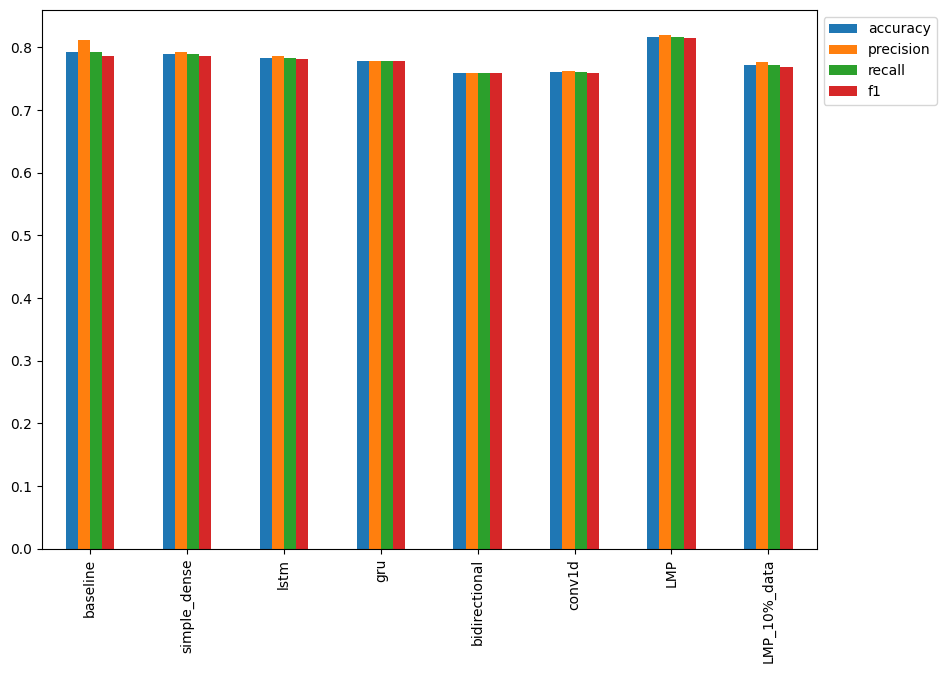

In [148]:
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

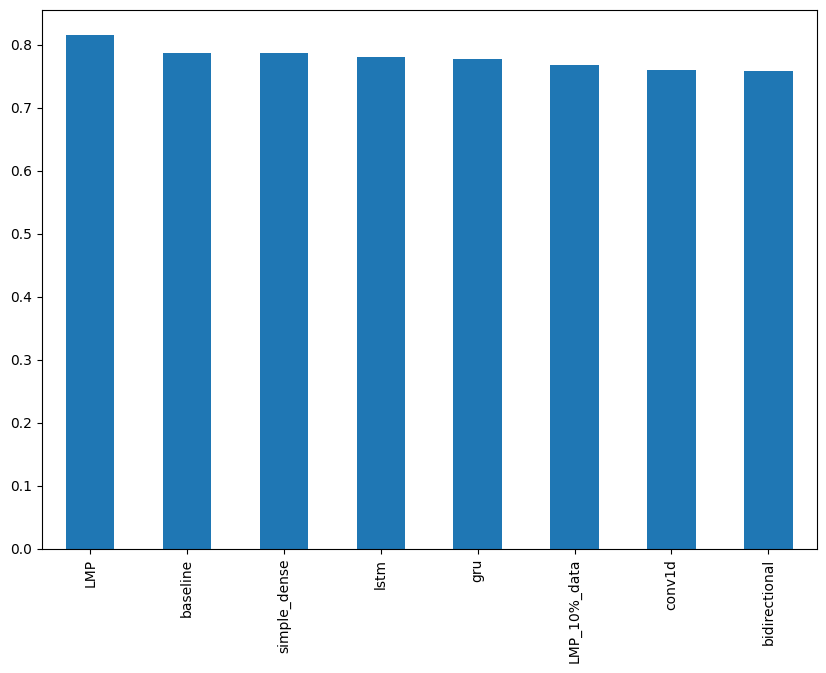

In [149]:
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

## TensorBoard Visualisation

In [150]:
!tensorboard dev upload --logdir ./model_logs/ \
  --name "08-NLP_with_tensorFlow: models" \
  --one_shot

2023-08-06 13:10:08.956060: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/saVHLDijS52rXXkqFkETaw/

[2023-08-06T13:10:11] Started scanning logdir.
[2023-08-06T13:10:24] Total uploaded: 420 scalars, 0 tensors, 14 binary objects (5.7 MB)
[2023-08-06T13:10:24] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/saVHLDijS52rXXkqFkETaw/


In [153]:
!tensorboard dev list

2023-08-06 13:16:54.749276: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/saVHLDijS52rXXkqFkETaw/
	Name                 08-NLP_with_tensorFlow: models
	Description          [No Description]
	Id                   saVHLDijS52rXXkqFkETaw
	Created              2023-08-06 13:10:11 (6 minutes ago)
	Updated              2023-08-06 13:10:24 (6 minutes ago)
	Runs                 28
	Tags                 5
	Scalars              420
	Tensor bytes         0
	Binary object bytes  5929497
https://tensorboard.dev/experiment/nbMl3TkHRgmbhZDBX1Imdg/
	Name                 Transfer learning experiments
	Description          A series of different transfer learning experiments with varying amounts of data and fine-tuning
	Id                   nbMl3TkHRgmbhZDBX1Imdg
	Created              2023-07-01 12:18:53
	Updated              2023-07-01 12:19:00
	Runs                 14
	Tags                 5
	Scalars              228
	

# Saving and loading models

## Saving

In [155]:
model_1.save('/content/drive/MyDrive/Colab Notebooks/Saved Models/NLP_model_1_basic_structure')
model_2.save('/content/drive/MyDrive/Colab Notebooks/Saved Models/NLP_model_2_LSTM')
model_3.save('/content/drive/MyDrive/Colab Notebooks/Saved Models/NLP_model_3_GRU')
model_4.save('/content/drive/MyDrive/Colab Notebooks/Saved Models/NLP_model_4_Bidirectional_LSTM')
model_5.save('/content/drive/MyDrive/Colab Notebooks/Saved Models/NLP_model_5_Conv_1D')
model_6.save('/content/drive/MyDrive/Colab Notebooks/Saved Models/NLP_model_6_NLP')
model_7.save('/content/drive/MyDrive/Colab Notebooks/Saved Models/NLP_model_7_NLP_less_data')

## Loading

In [156]:
# Model_1
model_1 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Saved Models/NLP_model_1_basic_structure')
ev_m1 = model_1.evaluate(val_sentences, val_labels)
model_1_pred_probs = model_1.predict(val_sentences)
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
res_m1 = TfCommon.calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)

24/24 [==============================] - 0s 6ms/step


In [157]:
# Model_2
model_2 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Saved Models/NLP_model_2_LSTM')
ev_m2 = model_2.evaluate(val_sentences, val_labels)
model_2_pred_probs = model_2.predict(val_sentences)
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
res_m2 = TfCommon.calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)

24/24 [==============================] - 1s 4ms/step


In [158]:
# Model_3
model_3 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Saved Models/NLP_model_3_GRU')
ev_m3 = model_3.evaluate(val_sentences, val_labels)
model_3_pred_probs = model_3.predict(val_sentences)
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
res_m3 = TfCommon.calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)

24/24 [==============================] - 1s 5ms/step


In [159]:
# Model_4
model_4 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Saved Models/NLP_model_4_Bidirectional_LSTM')
ev_m4 = model_4.evaluate(val_sentences, val_labels)
model_4_pred_probs = model_4.predict(val_sentences)
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
res_m4 = TfCommon.calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds)

24/24 [==============================] - 1s 3ms/step


In [160]:
# Model_5
model_5 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Saved Models/NLP_model_5_Conv_1D')
ev_m5 = model_5.evaluate(val_sentences, val_labels)
model_5_pred_probs = model_5.predict(val_sentences)
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
res_m5 = TfCommon.calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)

24/24 [==============================] - 0s 3ms/step


In [161]:
# Model_6
model_6 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Saved Models/NLP_model_6_NLP')
ev_m6 = model_6.evaluate(val_sentences, val_labels)
model_6_pred_probs = model_6.predict(val_sentences)
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
res_m6 = TfCommon.calculate_results(y_true=val_labels,
                                    y_pred=model_6_preds)

24/24 [==============================] - 1s 10ms/step


In [162]:
# Model_7
model_7 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Saved Models/NLP_model_7_NLP_less_data')
ev_m7 = model_7.evaluate(val_sentences, val_labels)
model_7_pred_probs = model_7.predict(val_sentences)
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
res_m7 = TfCommon.calculate_results(y_true=val_labels,
                                    y_pred=model_7_preds)

24/24 [==============================] - 1s 10ms/step


# Finding the most wrong predictions

In [163]:
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_preds,
                       "pred_prob": tf.squeeze(model_6_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.147351
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.738424
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.984837
3,@camilacabello97 Internally and externally scr...,1,0.0,0.198737
4,Radiation emergency #preparedness starts with ...,1,1.0,0.753327


In [164]:
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.914427
759,FedEx will no longer transport bioterror patho...,0,1.0,0.857123
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.843351
628,@noah_anyname That's where the concentration c...,0,1.0,0.842315
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.830030
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.818948
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.792105
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.774555
698,åÈMGN-AFRICAå¨ pin:263789F4 åÈ Correction: Ten...,0,1.0,0.764258
144,The Sound of Arson,0,1.0,0.760042


In [166]:
for row in most_wrong[:3].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1, Prob: 0.9144265651702881
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1, Prob: 0.8571230173110962
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1, Prob: 0.8433511257171631
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----



In [167]:
for row in most_wrong[-3:].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0, Prob: 0.03852048143744469
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

----

Target: 1, Pred: 0, Prob: 0.033260371536016464
Text:
Why are you deluged with low self-image? Take the quiz: http://t.co/XsPqdOrIqj http://t.co/CQYvFR4UCy

----

Target: 1, Pred: 0, Prob: 0.027756743133068085
Text:
Ron &amp; Fez - Dave's High School Crush https://t.co/aN3W16c8F6 via @YouTube

----



In [168]:
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 3)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6.predict([test_sample]))
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("----\n")

1/1 [==============================] - 0s 122ms/step
Pred: 0, Prob: 0.05457502231001854
Text:
Debate question: The robots have become self aware; do with destroy them thus thrusting the world into a tech-free life or re-enslave them?

----

1/1 [==============================] - 0s 60ms/step
Pred: 1, Prob: 0.8493843078613281
Text:
Fire That Destroyed Charlton Winery Ruled To Be Arson http://t.co/4a9l0jrMYB

----

1/1 [==============================] - 0s 101ms/step
Pred: 1, Prob: 0.9251634478569031
Text:
BREAKING NEWS: Australia collapse to a hapless 60 all out at Trent Bridge http://t.co/O2CFWDzZld

----



In [169]:
def predict_on_sentence(model, sentence):
  """
  Uses model to make a prediction on sentence.

  Returns the sentence, the predicted label and the prediction probability.
  """
  pred_prob = model.predict([sentence])
  pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
  print(f"Pred: {pred_label}", "(real disaster)" if pred_label > 0 else "(not real disaster)", f"Prob: {pred_prob[0][0]}")
  print(f"Text:\n{sentence}")

In [174]:
predict_on_sentence(model=model_6, sentence='Explosive BANANA!!!')

1/1 [==============================] - 0s 153ms/step
Pred: 0.0 (not real disaster) Prob: 0.10788767784833908
Text:
Explosive BANANA!!!


# The speed/score tradeoff

In [176]:
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.

  Args:
  ----
  model = a trained model
  sample = a list of samples

  Returns:
  ----
  total_time = total elapsed time for model to make predictions on samples
  time_per_pred = time in seconds per single sample
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time-start_time # calculate how long predictions took to make
  time_per_pred = total_time/len(val_sentences) # find prediction time per sample
  return total_time, time_per_pred

In [178]:
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.1396158679999644, 0.0001832229238844677)

In [184]:
model_1_total_pred_time, model_1_time_per_pred = pred_timer(model_1, val_sentences)
model_2_total_pred_time, model_2_time_per_pred = pred_timer(model_2, val_sentences)
model_3_total_pred_time, model_3_time_per_pred = pred_timer(model_3, val_sentences)
model_4_total_pred_time, model_4_time_per_pred = pred_timer(model_4, val_sentences)
model_5_total_pred_time, model_5_time_per_pred = pred_timer(model_5, val_sentences)
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6, val_sentences)
model_7_total_pred_time, model_7_time_per_pred = pred_timer(model_7, val_sentences)

model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 0s 16ms/step


(0.5817671619997782, 0.000763473965878974)

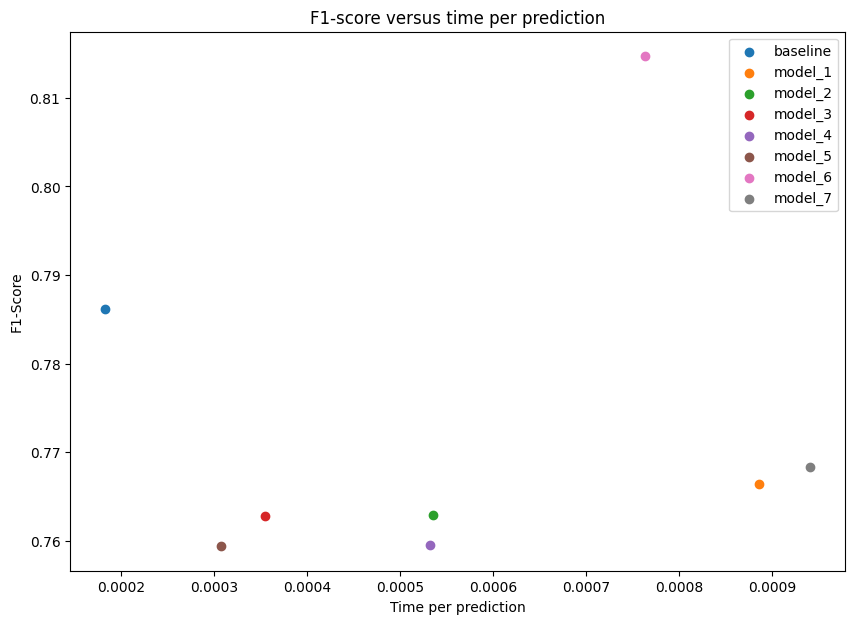

In [186]:
plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, res_m0["f1"], label="baseline")
plt.scatter(model_1_time_per_pred, res_m1["f1"], label="model_1")
plt.scatter(model_2_time_per_pred, res_m2["f1"], label="model_2")
plt.scatter(model_3_time_per_pred, res_m3["f1"], label="model_3")
plt.scatter(model_4_time_per_pred, res_m4["f1"], label="model_4")
plt.scatter(model_5_time_per_pred, res_m5["f1"], label="model_5")
plt.scatter(model_6_time_per_pred, res_m6["f1"], label="model_6")
plt.scatter(model_7_time_per_pred, res_m7["f1"], label="model_7")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-Score");